## **Verification of correlation between numerical and analytical noise**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import healpy
import h5py

# Conditions

In [2]:
dObs=100 #en Mpc
Tobs=3.145e+7 #364jours

In [3]:
orbit_file_name='/local/home/dd274198/Documents/lisaenv/keplerian-orbits-1-0-2.h5'
with h5py.File(orbit_file_name, 'r') as fi:
    orbit_t0 = fi.attrs['t0']
    duration=fi.attrs['tduration']
    #print(fi.attrs.keys())
    print(duration)

dObs=100 
dt=25
N=(int((Tobs-(orbit_t0 + 10))/dt))
N_i=(int((Tobs//2-(orbit_t0 + 10))/dt))
print(N_i)
t = orbit_t0 + 10 + np.linspace(0,Tobs,int(N_i))
#print(len(t))
#print(int(dt*int(N_i)))

31536000.0
628999


In [4]:
#Instrument

In [5]:
dt=10
dt_instru=2.5
N_instru=int((Tobs-(orbit_t0 + 10))/2/(dt_instru))
print(N_instru)
N_sim=786250 #limitation due to orbit file
t0=orbit_t0 + 10
Tmax=N_sim*dt_instru
t_i=t0+np.linspace(0,Tmax,int(N_sim))
print(len(t_i))

6289998
786250


In [6]:
import lisainstrument
from lisainstrument import Instrument
import pytdi
import pytdi.michelson
from pytdi.michelson import X2, Y2, Z2
from pytdi import Data

#skipped = int(1e4)
central_freq = 2.816E14

instru_n = Instrument(t0=orbit_t0 + 10, size=N_sim,physics_upsampling=4,dt=10,orbits=orbit_file_name, central_freq=central_freq, 
                      lock='six',aafilter=None)
instru_n.disable_all_noises(but='pathlength')
#instru_n.disable_all_noises(but='clock')
#instru_n.disable_all_noises(but='modulation')
instru_n.simulate()

data = pytdi.Data.from_instrument(instru_n)
X2n_built = pytdi.michelson.X2.build(**data.args)
data_X2n = X2n_built(data.measurements)/central_freq
Y2n_built = pytdi.michelson.Y2.build(**data.args)
data_Y2n = Y2n_built(data.measurements)/central_freq
Z2n_built = pytdi.michelson.Z2.build(**data.args)
data_Z2n = Z2n_built(data.measurements)/central_freq

#data_A2_n = (data_Z2_n - data_X2_n) / np.sqrt(2)
#data_E2_n = (data_X2_n - 2 * data_Y2_n + data_Z2_n) / np.sqrt(6)
#data_T2_n = (data_X2_n + data_Y2_n + data_Z2_n) / np.sqrt(3)

# Noise in time domain

Text(0, 0.5, 'amplitude')

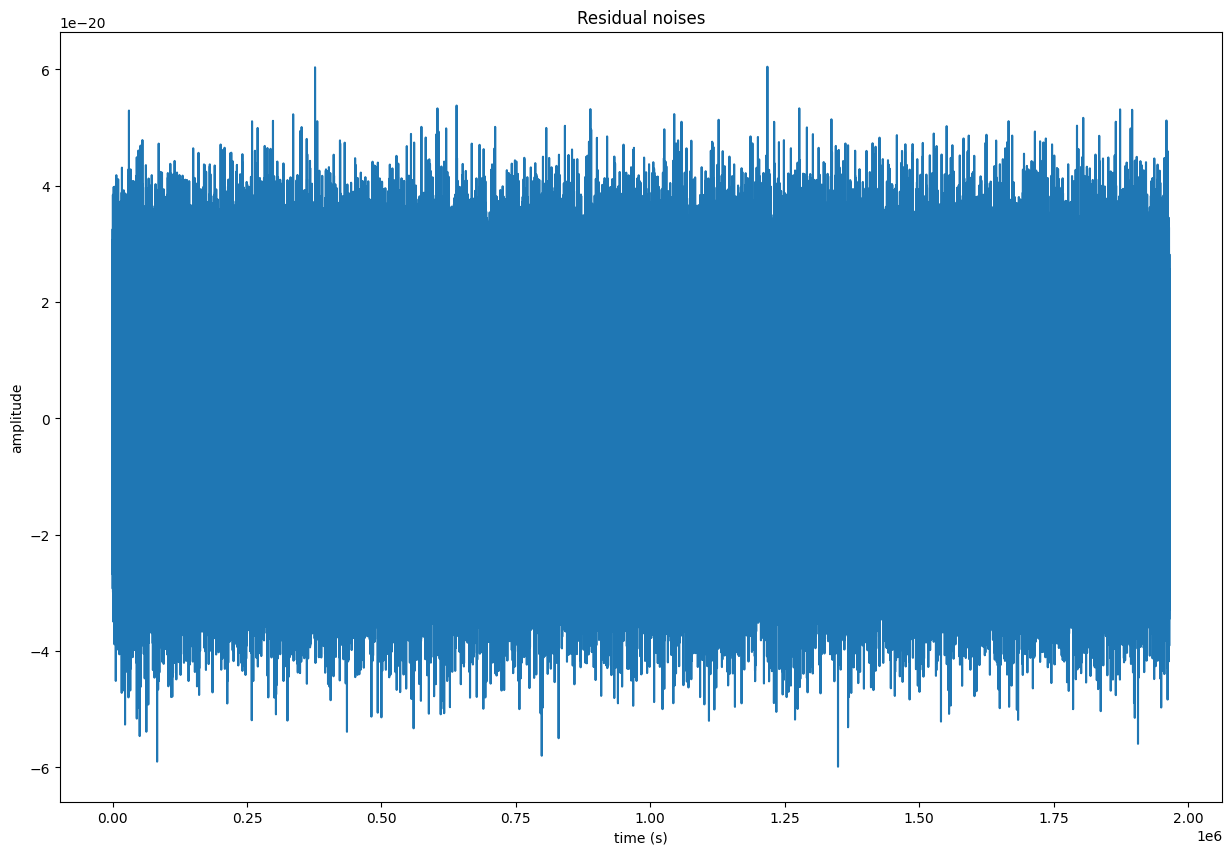

In [7]:
plt.figure(figsize=(15,10))
plt.plot(t_i[10:-10], data_X2n[10:-10])
#plt.plot(t[1000:], data_E2_n[1000:])
#plt.plot(t[1000:], data_T2_n[1000:])
plt.title('Residual noises')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
#plt.ylim([-0.25e-20,0.25e-20])


In [8]:
#fonction Périodogramme

In [13]:
def Pd_num(x,dt):
    window=np.blackman(len(x))
    N_w=np.sum(window**2)
    return dt*(2/N_w)*(np.abs(np.fft.rfft(window*x)))**2

In [16]:
import ldc
from ldc.lisa.noise import get_noise_model
from ldc.lisa.noise import NumericNoise
AddLDC = True

f= np.fft.rfftfreq(N_sim,d=dt)
## Noise level in the Science Requirement Document

PSD_sciRD_X2_usb = get_noise_model("SciRDv1",f[1:]).psd(option='X',tdi2=True)
#PSD_sciRD_A2_usb = get_noise_model("SciRDv1",f).psd(option='A',tdi2=True)
#PSD_sciRD_E2_usb = get_noise_model("SciRDv1",f).psd(option='E',tdi2=True)
#PSD_sciRD_T2_usb = get_noise_model("SciRDv1",f).psd(option='T',tdi2=True)

print((f))

[0.00000000e+00 1.27186010e-07 2.54372019e-07 ... 4.99997456e-02
 4.99998728e-02 5.00000000e-02]


(1e-05, 0.06)

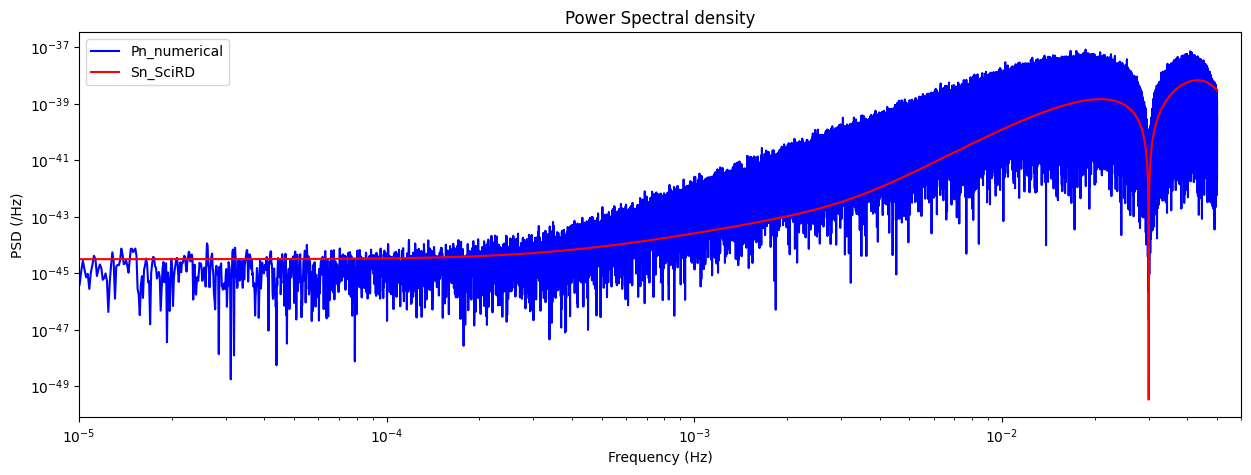

In [17]:
plt.figure(figsize=(15,5))
plt.loglog(f[1:],Pd_num(data_X2n,dt)[1:],label='Pn_numerical',c='blue')
plt.loglog(f[1:],PSD_sciRD_X2_usb, label='Sn_SciRD',c='red')
plt.legend()
plt.title('Power Spectral density')
plt.ylabel('PSD (/Hz)')
plt.xlabel('Frequency (Hz)')
plt.xlim([1e-5,6e-2])

